# 0. Setting Up The Env

## 0.1 Packages

In [1]:
from pathlib import Path

In [2]:
import pandas as pd 
import numpy as np


from scipy.stats import chi2_contingency

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [5]:
from mpl_toolkits.mplot3d import Axes3D

## 0.2 Utilities

In [6]:
def get_dummies_drop_least(df, cols):
    df_new = df.copy()
    for col in cols:
        # Category with the fewest values
        least_common = df[col].value_counts().idxmin()
        
        # One-hot encode
        dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
        
        # Drop the least frequent category
        dummies = dummies.drop(f"{col}_{least_common}", axis=1)
        
        df_new = df_new.drop(columns=[col]).join(dummies)
    
    return df_new

## 0.3 Constants

In [7]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [8]:
raw_file_path = f"{project_root}/data/raw/bank-full.csv"
processed_file_path = f"{project_root}/data/processed/preprocessed_bank.csv"
raw_file_path, processed_file_path

('d:\\01 Work\\06-Segmentations/data/raw/bank-full.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank.csv')

# 1. The Data

In [9]:
data_df  = pd.read_csv(raw_file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 45211 rows and 17 columns
Data Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 2. Data Changes

## 2.1 Categorical To Numerical

In [10]:
new_data_df = data_df.copy(deep=True)


In [11]:
new_data_df['num_month'] = new_data_df['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
new_data_df['sin_month'] = np.sin(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df['cos_month'] = np.cos(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df.drop(columns=["month", "num_month"], inplace=True)

## 2.2 Categorical To Binary

In [12]:
temp = new_data_df.describe(include=['O']).T
temp = temp[temp["unique"] == 2].index.tolist()
temp

['default', 'housing', 'loan', 'y']

In [13]:
for col in temp:
    new_data_df[col] = new_data_df[col].map({"yes": 1, "no": 0})

new_data_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,poutcome,y,sin_month,cos_month
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,-1,0,unknown,0,0.5,-0.866025
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,-1,0,unknown,0,0.5,-0.866025
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,-1,0,unknown,0,0.5,-0.866025
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,-1,0,unknown,0,0.5,-0.866025
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,-1,0,unknown,0,0.5,-0.866025


## 2.3 Rest Categorical

In [14]:
temp = new_data_df.describe(include=['O']).T
temp = temp[temp["unique"] > 2].index.tolist()
temp

['job', 'marital', 'education', 'contact', 'poutcome']

In [15]:
df_encoded = get_dummies_drop_least(new_data_df, temp)
df_encoded.head() 

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,1,0,0,0,1,0,1,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,1,0,1,0,0,1,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,1,0,0,1,0,0,1,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,1,0,0,0,0,0,1,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,1,0,0,0,0,1,0,0,1


# 3. Plot

In [16]:
X = df_encoded.drop("y", axis = 1)
y = df_encoded.loc[:, "y"]

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

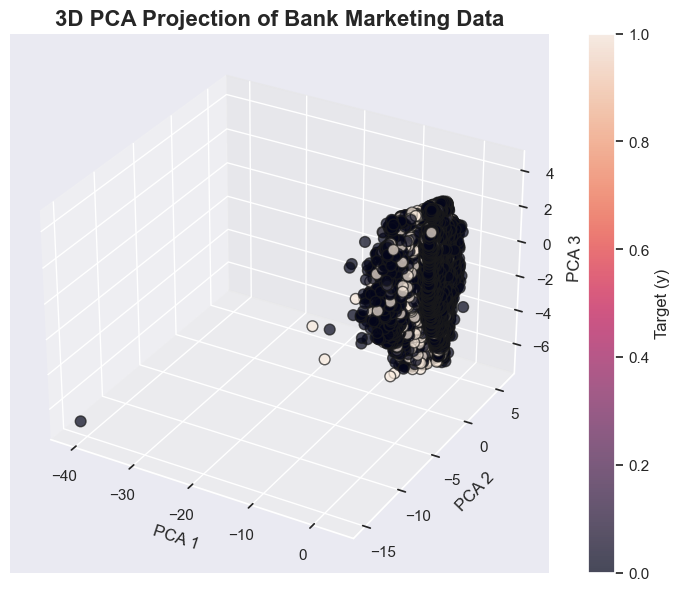

In [18]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

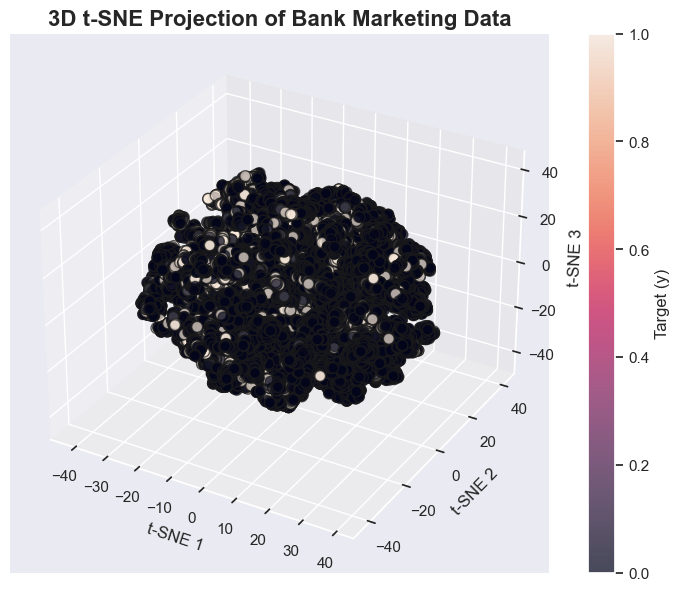

In [19]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 4. Save

In [20]:
df_encoded.to_csv(processed_file_path, index=False)

# END